###Все **установки**

In [1]:
!pip install typing_extensions==4.7.1 --upgrade --q
!python -m spacy download ru_core_news_sm --q
!pip install jsonlines
!pip install pymorphy2 --q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.4.1+cu121 requires typing-extensions>=4.8.0, but you have typing-extensions 4.7.1 which is incompatible.
typeguard 4.3.0 requires typing-extensions>=4.10.0, but you have typing-extensions 4.7.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 53.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup

###Bсе **import**

In [85]:
import json
import jsonlines
import pandas as pd
import spacy
from spacy.lang.ru.examples import sentences
from string import punctuation
import nltk
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

###Функция, удаляющая римские цифры из текста (римскими цифрамами обозначены главы в книге)

In [86]:
import re

def remove_roman_numerals(text):
    x = r'\bM{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})\b'
    cleaned_text = re.sub(x, '', text)
    return cleaned_text


###**ПЕРВОЕ ЗАДАНИЕ**

Предобработка текста

In [87]:
nlp = spacy.load("ru_core_news_sm")
with open('pushkin_a_s-text_0430.txt', 'r', encoding='utf-8') as file:
    text = file.read()
text = remove_roman_numerals(text)

###**ВТОРОЕ ЗАДАНИЕ**

####Обработатка книги с помощью Spacy

In [104]:
doc = nlp(text)
nlp.vocab["Annotation"].is_stop = True
nlp.vocab["annotation"].is_stop = True
nlp.vocab["Что"].is_stop = True
nlp.vocab["что"].is_stop = True
filtered_tokens = [token for token in doc if not token.is_stop] # убираем стоп слова из текста, добавив в стоп слова "Annotation"
freq = []
freq_dict = {}
with jsonlines.open('final_spacy.jsonl', mode='w') as jsonl_f: # записываем разборы всех слов в JSON Lines
  for token in filtered_tokens:
    if not token.is_punct and not token.is_space:
      tokens = {'lemma': token.lemma_,
                'word': token.text,
                'pos': token.pos_}
      jsonl_f.write(tokens)
      freq.append(tokens)
# print(freq)
for token in freq: # cоздаем словарь частотности лемм
  lemma = token['lemma']
  pos = token['pos']
  if lemma not in freq_dict:
    freq_dict[lemma] = {'pos': pos, 'frequency': 1}
  else:
    freq_dict[lemma]['frequency'] += 1
# print(freq_dict)

####Cоздание датафрейма частотности лемм в нашем тексте

In [105]:
df = pd.DataFrame.from_dict(freq_dict, orient='index').reset_index()
df.columns = ['lemma', 'pos', 'frequency']
df_spacy = df
sorted_df = df.sort_values(by='frequency', ascending=False)
sorted_df.to_csv('final_spacy .csv', encoding='utf-8')

###**ТРЕТЬЕ ЗАДАНИЕ**

####Обработатка книги с помощью NLTK

In [103]:
nltk.download('punkt')
my_text = word_tokenize(text, language='russian')
my_text = [w.lower() for w in word_tokenize(text, language='russian') if w.isalpha()]
nltk.download('stopwords')
sw = stopwords.words('russian')
sw.append('annotation') # опять добавляем annotation. в стоп слова
filtered = [w for w in my_text if w not in sw]
# print(filtered[:15])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


####Токенизация с помощью Pymorphy

In [91]:
morph = MorphAnalyzer()
results = []
result_dict = {}
with jsonlines.open('final_morph.jsonl', mode='w') as jsonl_f:
  for word in filtered:
    parsed_word = morph.parse(word)[0]
    result = {
        "lemma":parsed_word.normal_form,
        "word": word,
        "pos": str(parsed_word.tag.POS)
    }
    results.append(result)
    jsonl_f.write(result)
# print(results)
for token in results: # создаем словарь частотности лемм
  lemma = token['lemma']
  pos = token['pos']
  if lemma not in result_dict:
    result_dict[lemma] = {'pos': pos, 'frequency': 1}
  else:
    result_dict[lemma]['frequency'] += 1

####Cоздание датафрейма частотности лемм в нашем тексте

In [92]:
df = pd.DataFrame.from_dict(result_dict, orient='index').reset_index()
df.columns = ['lemma', 'pos', 'frequency']
df_morphy = df
df_morphy = df_morphy.dropna()
# df_morphy.info()
# print(df_morphy)
sorted_df = df.sort_values(by='frequency', ascending=False)
sorted_df.to_csv('final_morph .csv', encoding='utf-8', index=False)

###**ЧЕТВЁРТОЕ ЗАДАНИЕ**

####Создание отдельных датафреймов, в которых есть столбец 'pos' и столбец 'frequency' (в %)

In [106]:
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 10, 7
%config InlineBackend.figure_format = 'svg'

new_df_spacy = df_spacy['pos'].value_counts(normalize=True).reset_index() # создаем датафрейм для Spacy
new_df_spacy['proportion'] *= 100
print(new_df_spacy)
# df_morphy.info()

new_df_morphy = df_morphy['pos'].value_counts(normalize=True).reset_index() # создаем датафрейм для PyMorphy
new_df_morphy['proportion'] *= 100
# new_df_morphy.info()
print(new_df_morphy)
# print(df_spacy['pos'].unique())
# print(new_df_morphy['pos'].unique())
# print(new_df_morphy['proportion'].unique())

      pos  proportion
0    NOUN   37.168950
1    VERB   32.876712
2     ADJ   14.703196
3   PROPN    8.721461
4     ADV    4.170472
5     NUM    1.552511
6   PUNCT    0.152207
7    PRON    0.136986
8     ADP    0.121766
9     DET    0.121766
10      X    0.106545
11   PART    0.091324
12   INTJ    0.030441
13  CCONJ    0.015221
14  SCONJ    0.015221
15    AUX    0.015221
     pos  proportion
0   NOUN   39.183902
1   VERB   22.824669
2   ADJF   13.676169
3   ADVB    6.260481
4   INFN    6.111422
5   GRND    2.347680
6   ADJS    2.235886
7   PRTF    2.179989
8   PRTS    1.416061
9   PREP    0.652133
10  CONJ    0.614869
11  NUMR    0.447177
12  INTJ    0.447177
13  NPRO    0.391280
14  None    0.372648
15  PRCL    0.335383
16  COMP    0.335383
17  PRED    0.167691


####Визуализация доли слов каждой часть речи

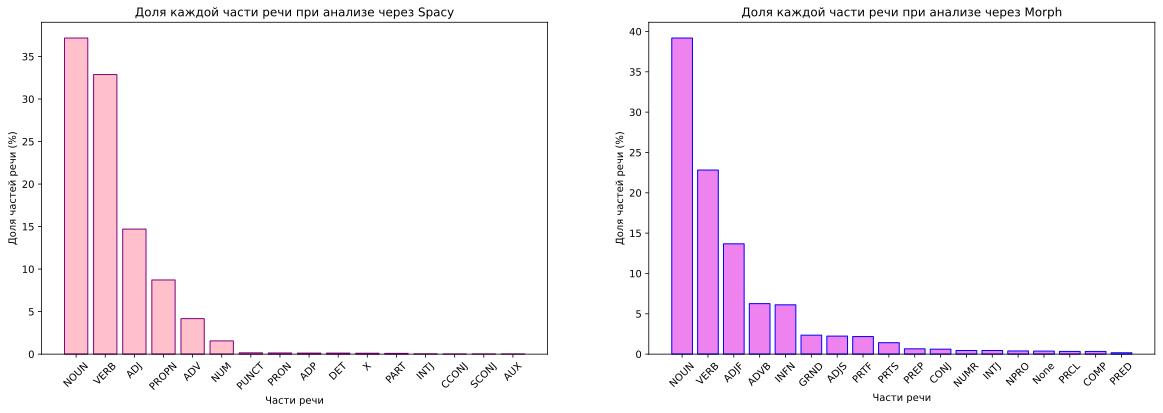

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
axs[0].set_title('Доля каждой части речи при анализе через Spacy') # строим график дляя результатов Spacy
axs[0].bar(new_df_spacy['pos'], new_df_spacy['proportion'], color='pink', edgecolor = 'purple')
axs[0].set_ylabel("Доля частей речи (%)")
axs[0].set_xlabel("Части речи")
axs[0].tick_params(axis='x', rotation=45)

axs[1].set_title('Доля каждой части речи при анализе через Morph') # строим график для результатов PyMorphy
axs[1].bar(new_df_morphy['pos'], new_df_morphy['proportion'], color='violet', edgecolor = 'blue')
axs[1].set_ylabel("Доля частей речи (%)")
axs[1].set_xlabel("Части речи")
axs[1].tick_params(axis='x', rotation=45)
plt.show()

Рассмотрим полученные данные:
1. Доля *существительных* вне зависимости от метода обработки (Spacy или PyMorphy) примерно одинакова (около 40%). Существительное - наиболее частотная часть речи
2. *Глаголы*:
- Анализ Spacy: доля составляет почти 33%
- Анализ PyMorphy: если объединить 3 тэга (VERB, INFN, GRND), то получится около 32,5 %
3. *Прилагательные*: соотношение между полученными результатами при помощи двух разных библиотек, в целом, совпадают

*Общий вывод*: в целом, данные похожи, но в PyMorphy более дробное тэгерирование лемм по частям речи


####Составление, визуализация и сравнение топ 20 глаголовов и топ 20 наречий

#####Топ 20 глаголов

######1 способ, когда в PyMorphy мы за глаголы считаем только глаголы с тэгом VERB, и когда в Spacy за глаголы счиатем только глаголы с тэгом VERB

In [108]:
top20_verbs_s = df_spacy[df_spacy['pos'] == 'VERB'].nlargest(20, 'frequency')

top20_verbs_m = df_morphy[df_morphy['pos'] == 'VERB'].nlargest(20, 'frequency')

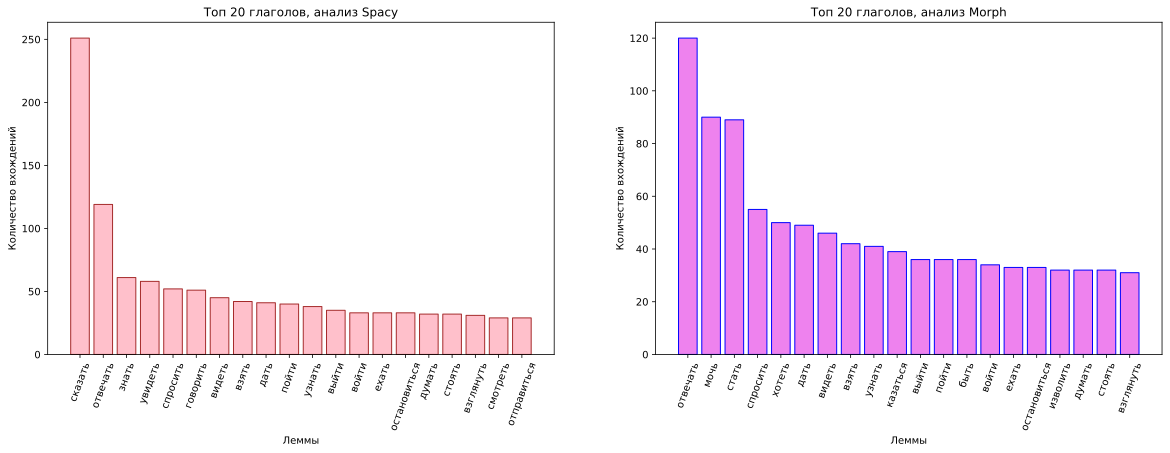

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
axs[0].set_title('Топ 20 глаголов, анализ Spacy')
axs[0].bar(top20_verbs_s['lemma'], top20_verbs_s['frequency'], color='pink', edgecolor = 'brown')
axs[0].set_ylabel("Количество вхождений")
axs[0].set_xlabel("Леммы")
axs[0].tick_params(axis='x', rotation=70)


axs[1].set_title('Топ 20 глаголов, анализ Morph')
axs[1].bar(top20_verbs_m['lemma'], top20_verbs_m['frequency'], color='violet', edgecolor = 'blue')
axs[1].set_ylabel("Количество вхождений")
axs[1].set_xlabel("Леммы")
axs[1].tick_params(axis='x', rotation=70)

plt.show()

######2 способ, когда в PyMorphy к глаголам также относим леммы с тэгом INFN (инфинитив), PRTS (краткие причастия (основная причина, по которой я их сюда отнесла - это глагол "сказать" с 250-ю вхождениями)) и GRND (деепричастия).

In [110]:
top20_verbs_s_2 = df_spacy[df_spacy['pos'] == 'VERB'].nlargest(20, 'frequency')

top20_verbs_pre_v = df_morphy[df_morphy['pos'] == 'VERB'].nlargest(20, 'frequency')
top20_verbs_pre_in = df_morphy[df_morphy['pos'] == 'INFN'].nlargest(20, 'frequency')
top20_verbs_pre_prts = df_morphy[df_morphy['pos'] == 'PRTS'].nlargest(20, 'frequency')
top20_verbs_pre_gr = df_morphy[df_morphy['pos'] == 'GRND'].nlargest(20, 'frequency')
top20_verbs_m_2 = pd.concat([top20_verbs_pre_v, top20_verbs_pre_in, top20_verbs_pre_prts, top20_verbs_pre_gr]).nlargest(20, 'frequency')

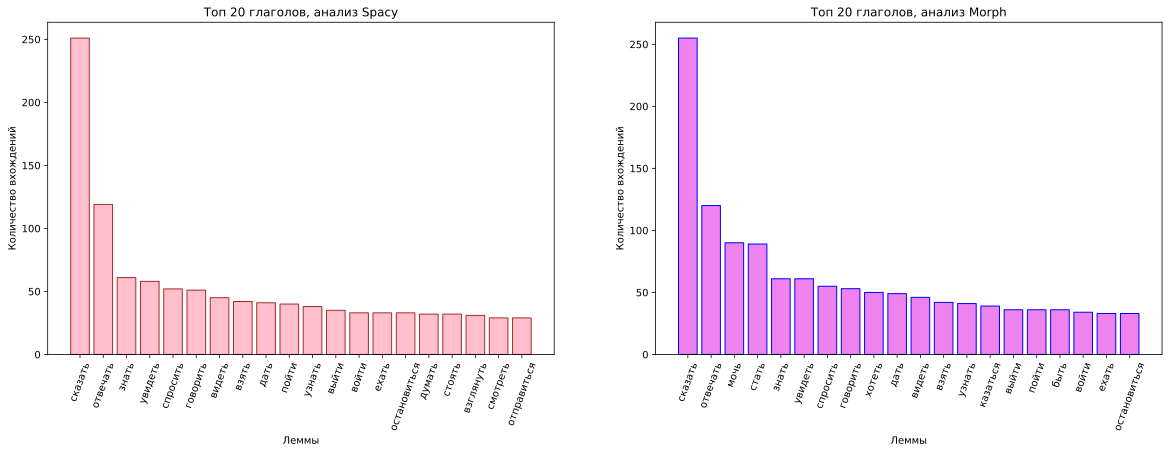

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
axs[0].set_title('Топ 20 глаголов, анализ Spacy')
axs[0].bar(top20_verbs_s_2['lemma'], top20_verbs_s_2['frequency'], color='pink', edgecolor = 'brown')
axs[0].set_ylabel("Количество вхождений")
axs[0].set_xlabel("Леммы")
axs[0].tick_params(axis='x', rotation=70)


axs[1].set_title('Топ 20 глаголов, анализ Morph')
axs[1].bar(top20_verbs_m_2['lemma'], top20_verbs_m_2['frequency'], color='violet', edgecolor = 'blue')
axs[1].set_ylabel("Количество вхождений")
axs[1].set_xlabel("Леммы")
axs[1].tick_params(axis='x', rotation=70)

plt.show()

Как мы видим, из-за более дробного разделения на части речи в PyMorphy результаты, полученные 1 способом, сильно отличаются от результатов Spacy.
После проведенного анализа 2-м способом, можно заметить, в целом, результаты очень похожи. Различия в количество определенных глаголов могут быть в том, что Spacy учитывает контекст и может отнести что-то к другой части речи. Также различия связаны с тем, что PyMorphy записывает обычно наиболее вероятный разбор (рассчитанный по каким-то своим метрикам).

#####Топ 20 наречий

In [112]:
top20_adverbs_m = df_morphy[df_morphy['pos'] == 'ADVB'].nlargest(20, 'frequency')
top20_adverbs_s = df_spacy[df_spacy['pos'] == 'ADV'].nlargest(20, 'frequency')

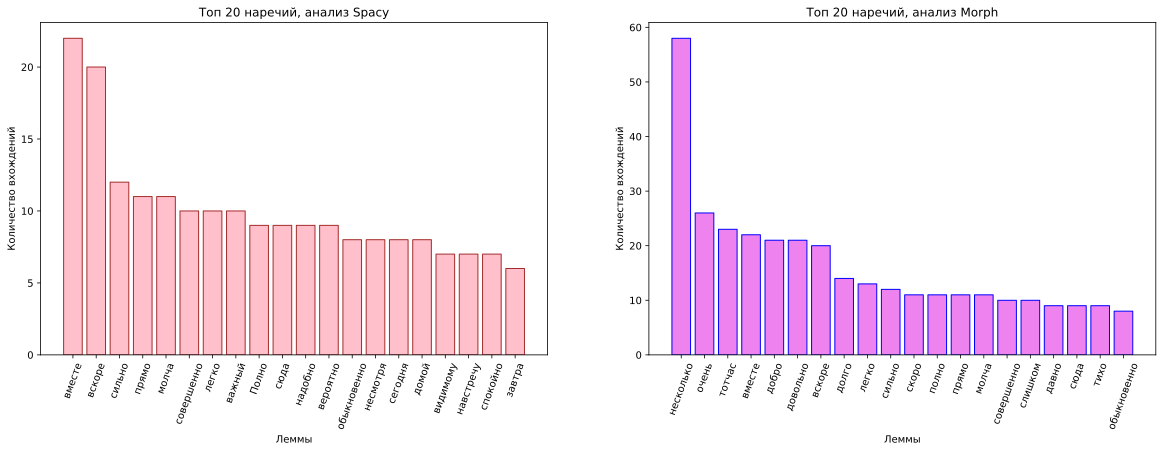

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
axs[0].set_title('Топ 20 наречий, анализ Spacy')
axs[0].bar(top20_adverbs_s['lemma'], top20_adverbs_s['frequency'], color='pink', edgecolor = 'brown')
axs[0].set_ylabel("Количество вхождений")
axs[0].set_xlabel("Леммы")
axs[0].tick_params(axis='x', rotation=70)


axs[1].set_title('Топ 20 наречий, анализ Morph')
axs[1].bar(top20_adverbs_m['lemma'], top20_adverbs_m['frequency'], color='violet', edgecolor = 'blue')
axs[1].set_ylabel("Количество вхождений")
axs[1].set_xlabel("Леммы")
axs[1].tick_params(axis='x', rotation=70)

plt.show()

Как мы видим, данные сильно различаются (хотя есть повторящиеся наречия (например, молча, сильно, прямо и др.)). Такое различие может быть связано опять же таки с тем, что Spacy пытается учитывать контекст, чтобы выбрать между той или иной части речи.
Вторая причина по которой могут быть различия - это различный список стоп слов, применненых при каждом из анализов.

####WordCloud Spacy

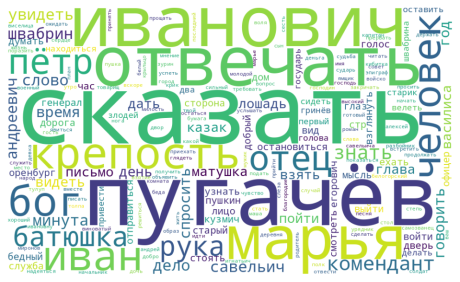

In [114]:
from wordcloud import WordCloud

df_spacy_cloud = df_spacy[df_spacy['lemma'].str.len() > 2]
word_freq_spacy_cl = {row['lemma']: row['frequency'] for _, row in df_spacy_cloud.iterrows()}
wordcloud = WordCloud(background_color='white', width=1000, height=600).generate_from_frequencies(word_freq_spacy_cl)
plt.figure(figsize =(8, 8), facecolor=None, dpi=150)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

####WordCloud PyMorphy

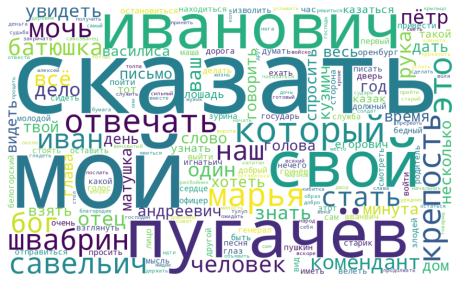

In [101]:
df_morphy_cloud = df_morphy[df_morphy['lemma'].str.len() > 2]
word_freq_morphy_cl = {row['lemma']: row['frequency'] for _, row in df_morphy_cloud.iterrows()}
wordcloud = WordCloud(background_color='white', width=1000, height=600).generate_from_frequencies(word_freq_morphy_cl)
plt.figure(figsize =(8, 8), facecolor=None, dpi=150)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Как мы видим, в обоих WordCloud присутсвует фамилия одного из главных героев (Пугачев), отчество Швабрина, имя главного героя (Пётр), а также имя возлюбленной Гринёва Марьи. Также глагол "сказать" занимает одну из лидирующих позицих на обоих WordCloud (как мы помним, 250 употреблений).
Также в WordCloud PyMorphy очень большие местоимения "мой" и "свой" - это может быть из-за списка лемм, включенных в стоп-слова.

###**ПЯТОЕ ЗАДАНИЕ**

In [23]:
from nltk.util import ngrams
bigrams_list = list(ngrams(filtered, 2))
trigrams_list = list(ngrams(filtered, 3))
bigrams_freq = {}
trigrams_freq = {}
for bigram in bigrams_list:
    if bigram in bigrams_freq:
        bigrams_freq[bigram] += 1
    else:
        bigrams_freq[bigram] = 1

trigrams_freq = {}
for trigram in trigrams_list:
    if trigram in trigrams_freq:
        trigrams_freq[trigram] += 1
    else:
        trigrams_freq[trigram] = 1

top_bigrams = sorted(bigrams_freq.items(), key=lambda item: item[1], reverse=True)[:25]

top_trigrams = sorted(trigrams_freq.items(), key=lambda item: item[1], reverse=True)[:25]

# print(top_bigrams, top_trigrams, sep='\n')

[(('марья', 'ивановна'), 83), (('петр', 'андреич'), 49), (('иван', 'кузмич'), 36), (('василиса', 'егоровна'), 30), (('ваше', 'благородие'), 20), (('слава', 'богу'), 19), (('иван', 'игнатьич'), 19), (('батюшка', 'петр'), 16), (('марью', 'ивановну'), 16), (('марье', 'ивановне'), 14), (('белогорскую', 'крепость'), 12), (('марьи', 'ивановны'), 12), (('самом', 'деле'), 11), (('алексей', 'иваныч'), 10), (('белогорской', 'крепости'), 10), (('несколько', 'минут'), 10), (('сказал', 'пугачев'), 10), (('заячий', 'тулуп'), 9), (('делать', 'нечего'), 9), (('капитана', 'миронова'), 9), (('ивана', 'кузмича'), 9), (('марьей', 'ивановной'), 9), (('час', 'часу'), 8), (('это', 'значит'), 8), (('крайней', 'мере'), 8)]
[(('батюшка', 'петр', 'андреич'), 16), (('прощайте', 'петр', 'андреич'), 5), (('ваше', 'благородие', 'сказал'), 5), (('петр', 'андреич', 'сказал'), 4), (('марья', 'ивановна', 'спросил'), 4), (('петр', 'андреич', 'сказала'), 4), (('воля', 'твоя', 'сударь'), 3), (('ваше', 'благородие', 'отвеча

Наиболее распространенные как биграммы, так и биграммы связаны с именами главных героев (потому что к ним обычно обращаются по ИО, либо еще добавляя обращение "благородие", "батюшка") или же с обращениями к ним (можно без имени; говоря о триграммах также распространено добавление самого распространненого глагола "спросить").

###**ШЕСТОЕ ЗАДАНИЕ**

In [115]:
text_inflection = 'Матушка была еще мною брюхата, как уже я был записан в Семеновский полк сержантом, по милости майора гвардии князя Б., близкого нашего родственника. Если бы паче всякого чаяния матушка родила дочь, то батюшка объявил бы куда следовало о смерти неявившегося сержанта, и дело тем бы и кончилось. Я считался в отпуску до окончания наук. В то время воспитывались мы не по-нонешнему. С пятилетнего возраста отдан я был на руки стремянному Савельичу, за трезвое поведение пожалованному мне в дядьки. Под его надзором на двенадцатом году выучился я русской грамоте и мог очень здраво судить о свойствах борзого кобеля. В это время батюшка нанял для меня француза, мосье Бопре, которого выписали из Москвы вместе с годовым запасом вина и прованского масла. Приезд его сильно не понравился Савельичу. "Слава богу,-- ворчал он про себя,-- кажется, дитя умыт, причесан, накормлен. Куда как нужно тратить лишние деньги и нанимать мусье, как будто и своих людей не стало!"'
# выше, это один из первых абзацев из моего произведения
nltk.download('punkt')
new_tokens = word_tokenize(text_inflection, language='russian')
new_tokens = [w.lower() for w in word_tokenize(text_inflection, language='russian') if w.isalpha()]
nltk.download('stopwords')
sw = stopwords.words('russian')
sw.append('annotation')
filtered_inflection = [w for w in new_tokens if w not in sw]
# print(filtered_inflection[:30])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
def change_form(word):
    wordword = morph.parse(word)[0] # у меня закончилась фантазия на названия переменных, простите

    if 'VERB' in wordword.tag:
        if 'past' in wordword.tag:
            new_form = parsed_word.inflect({'pres'})
        else:
            new_form = wordword.inflect({'past'})

        if new_form:
          new_word = new_form.word
    else:
        new_word = word

    if 'NOUN' in wordword.tag:
        if 'plur' in wordword.tag:
            new_form = wordword.inflect({'sing'})
        else:
            new_form = wordword.inflect({'plur'})

        if new_form:
          new_word = new_form.word
    else:
        new_word = word

    return new_word


words_new_tense_pl = [change_form(word) for word in filtered_inflection]
changed_text = ' '.join(words_new_tense_pl)
print(changed_text)

матушки мною брюхата записан семеновский полки сержантами милостей майоров гвардий князей близкого нашего родственников паче всякого чаяний матушки родила дочери батюшки объявил следовало смертей неявившегося сержантов дела кончилось считался отпускам окончаний науки времена воспитывались пятилетнего возрастов отдан руку стремянному савельичам трезвое поведения пожалованному дядька надзорами двенадцатом годы выучился русской грамотам мог очень здраво судить свойстве борзого кобелей это времена батюшки нанял французов мосье бопре которого выписали москвы вместе годовым запасами вин прованского масел приезды сильно понравился савельичам славы богам ворчал кажется дитя умыт причесан накормлен нужно тратить лишние деньгу нанимать мусья своих человека стало


к сожалению, соглосование сущ. и глаголов не получилось, потому что не совсем понятно как это делать, как учитывать местоимения и т.д. и не понятно как писать функцию, потому что у нас же сущ. не обязателно идет перед глаголом, их может что-то разрывать ... как понять какое сущ. управляет именно этим глаголом (((